In [117]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# KMeans

In [118]:
def kmeans_clustering(datasets):
    cluster_range = range(2, 11)

    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} for ngram in datasets}
    labels = []
    # Grid search
    for ngram, data in datasets.items():
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(data)
            labels = kmeans.labels_
            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data, labels))

    # Plotting metrics with cluster number for each n-gram
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    metrics = ["silhouette", "calinski", "davies"]
    
    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Number of Clusters")
            ax.set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

### Ebola Virus

In [119]:
# Read data from file for each n-gram and drop non-numerical columns

df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

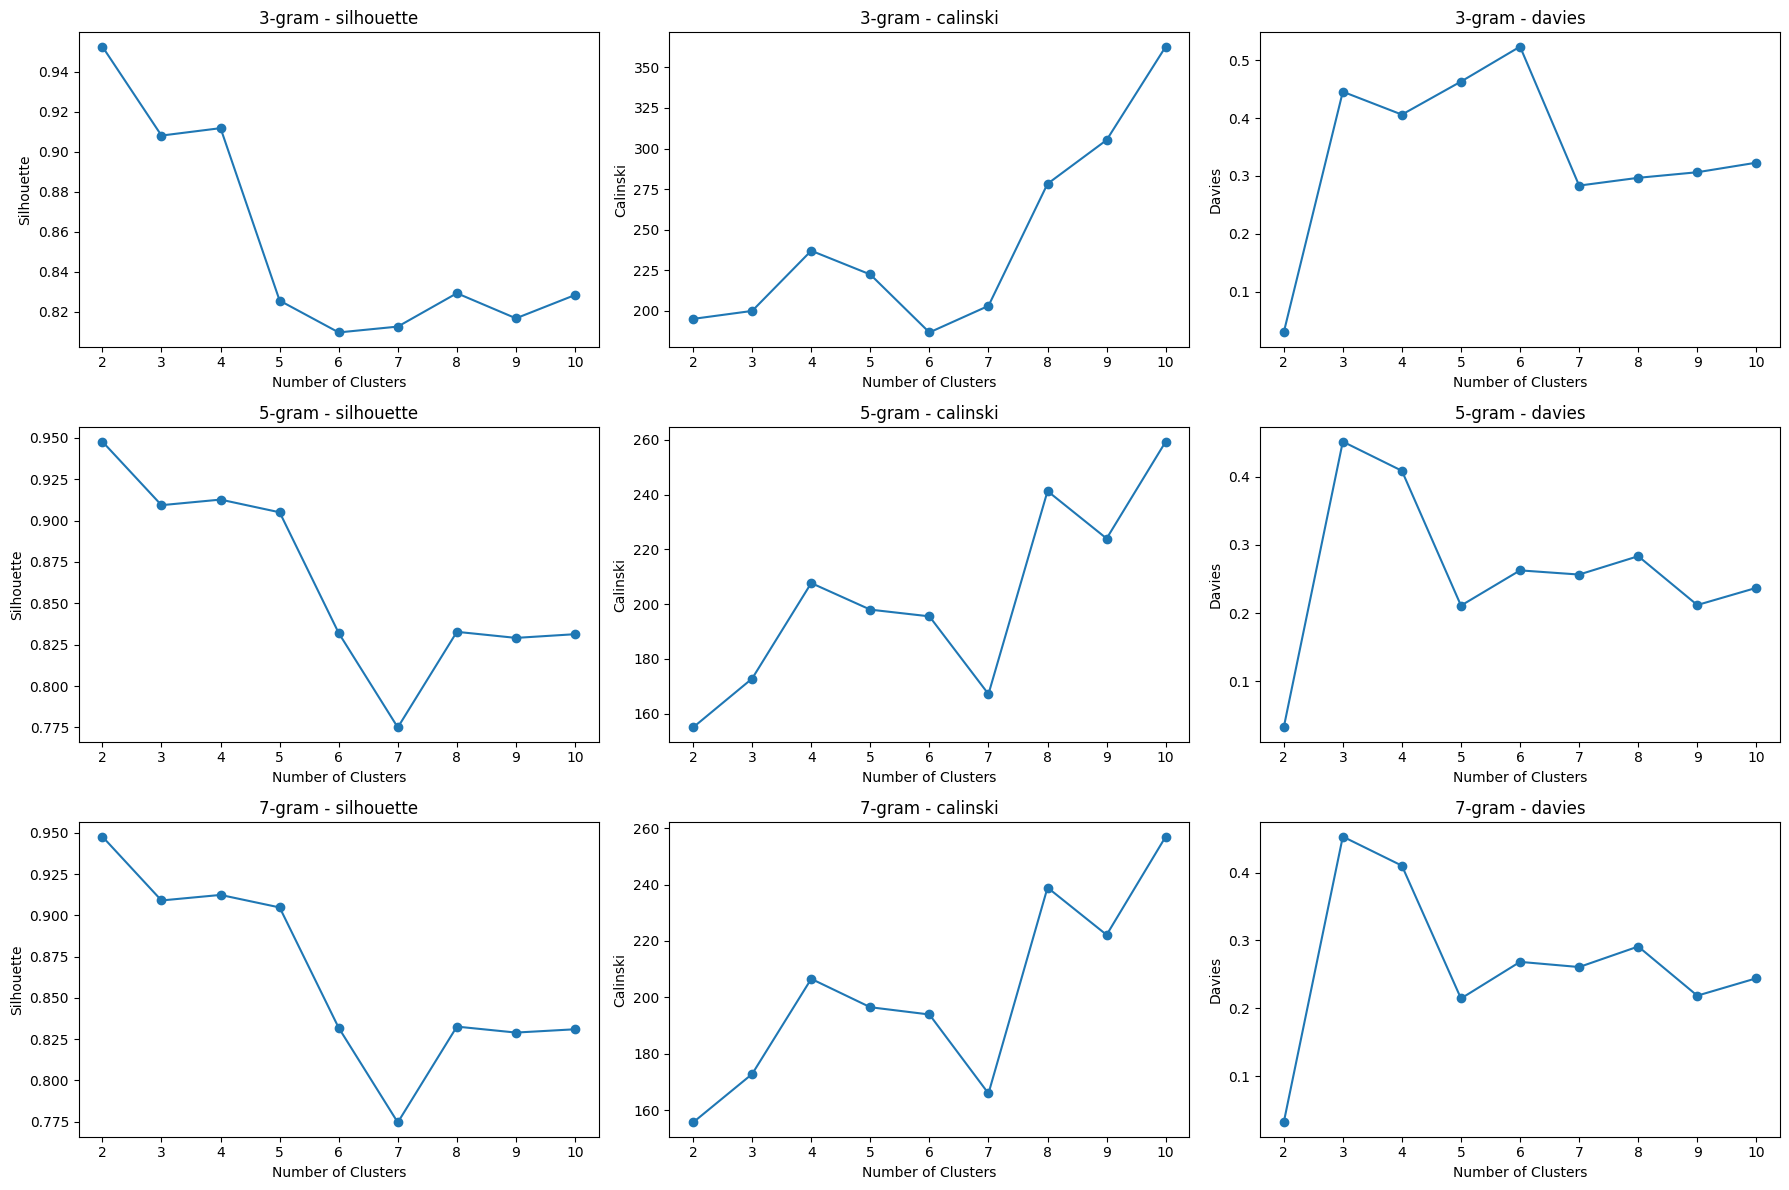

In [120]:
kmeans_clustering(datasets)

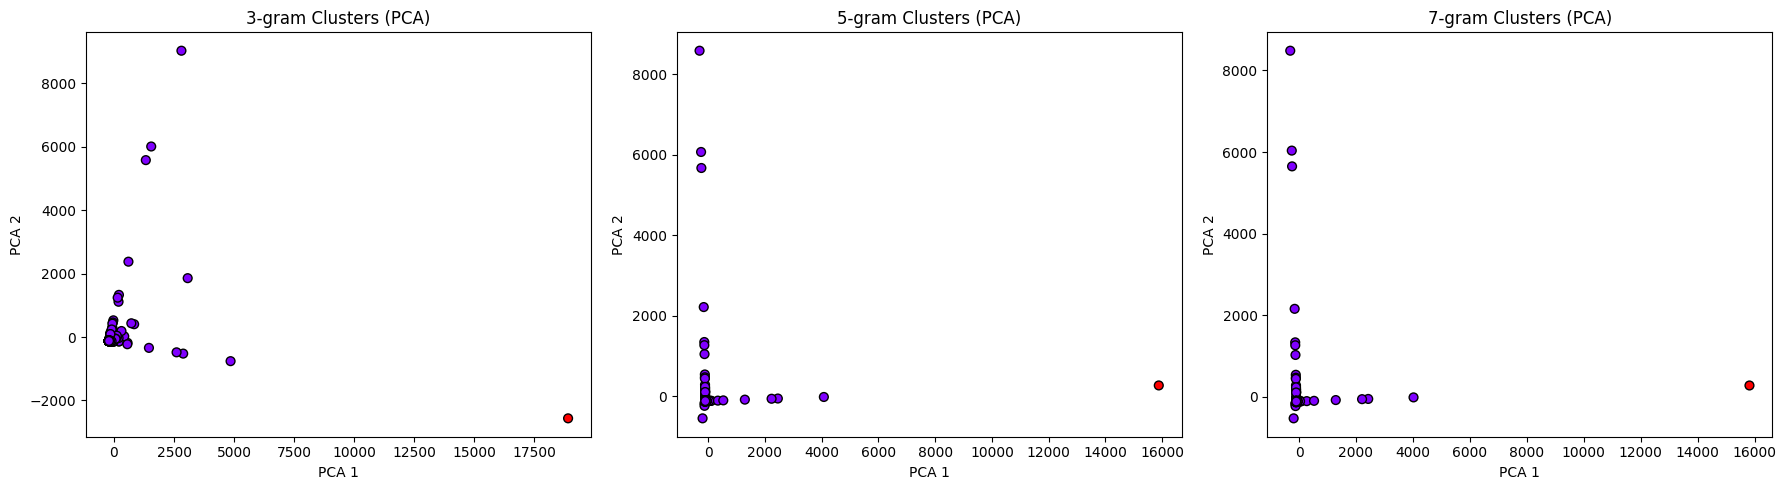

In [121]:
# Visualisation of clusterings
k = 2 # Because Silhouette and Davies are best with this number of clusters, even if Calinski increass
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, data) in zip(axes, datasets.items()):
    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(data)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(data)

    # Scatter plot
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="rainbow", s=40, edgecolor='k')
    ax.set_title(f"{label} Clusters (PCA)")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

### Marburg Virus

In [122]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

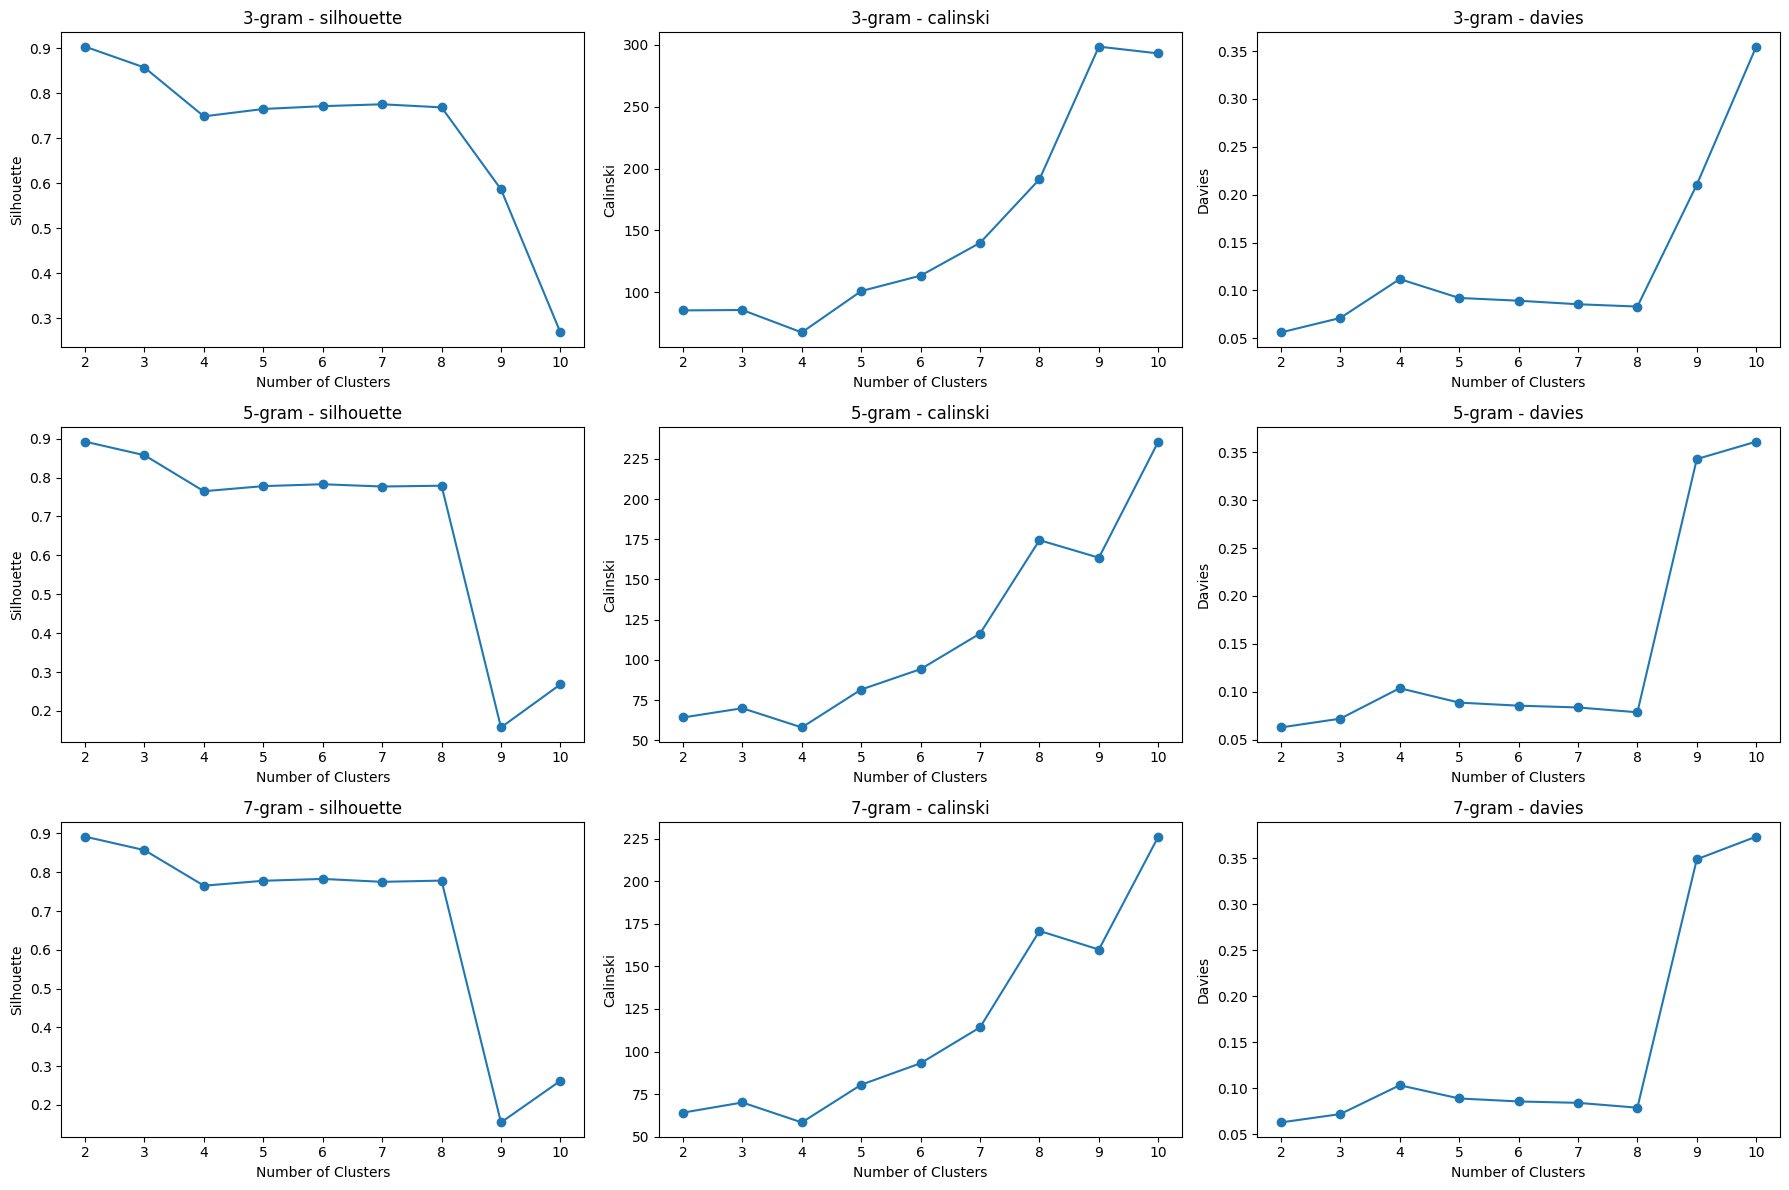

In [123]:
kmeans_clustering(datasets)

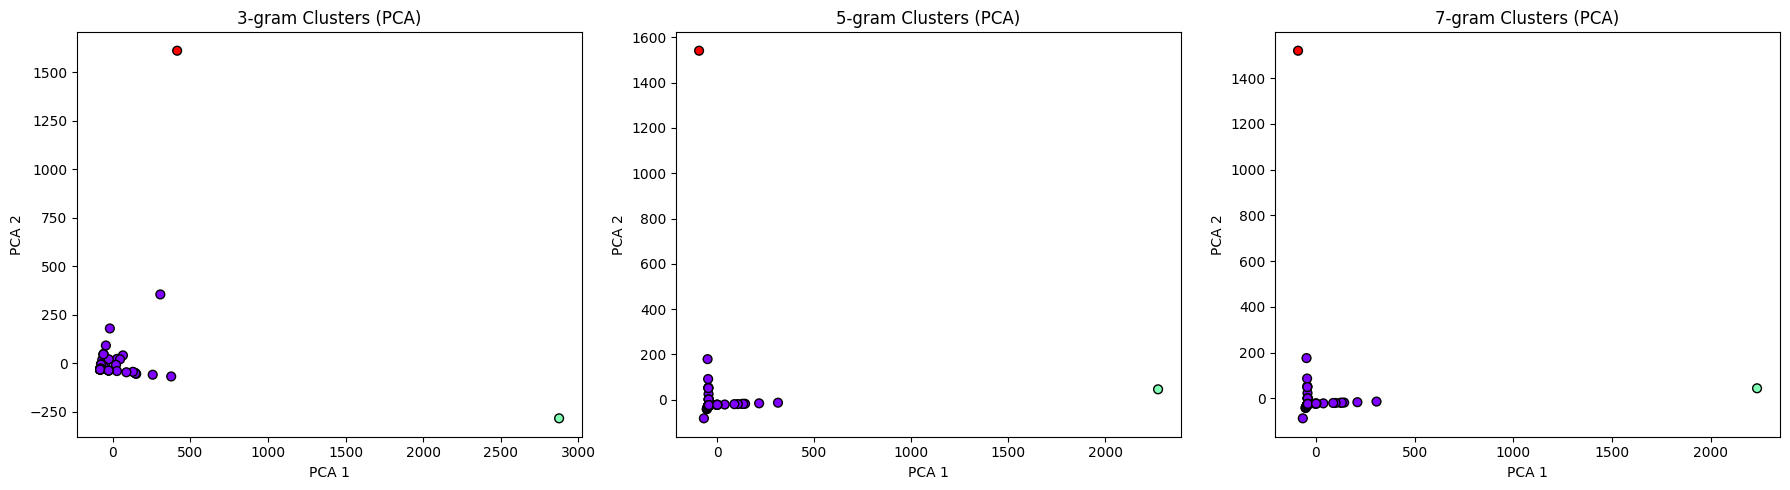

In [124]:
# Visualisation of clusterings
k = 3
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, data) in zip(axes, datasets.items()):
    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(data)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(data)

    # Scatter plot
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="rainbow", s=40, edgecolor='k')
    ax.set_title(f"{label} Clusters (PCA)")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

### Mers Virus

In [125]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

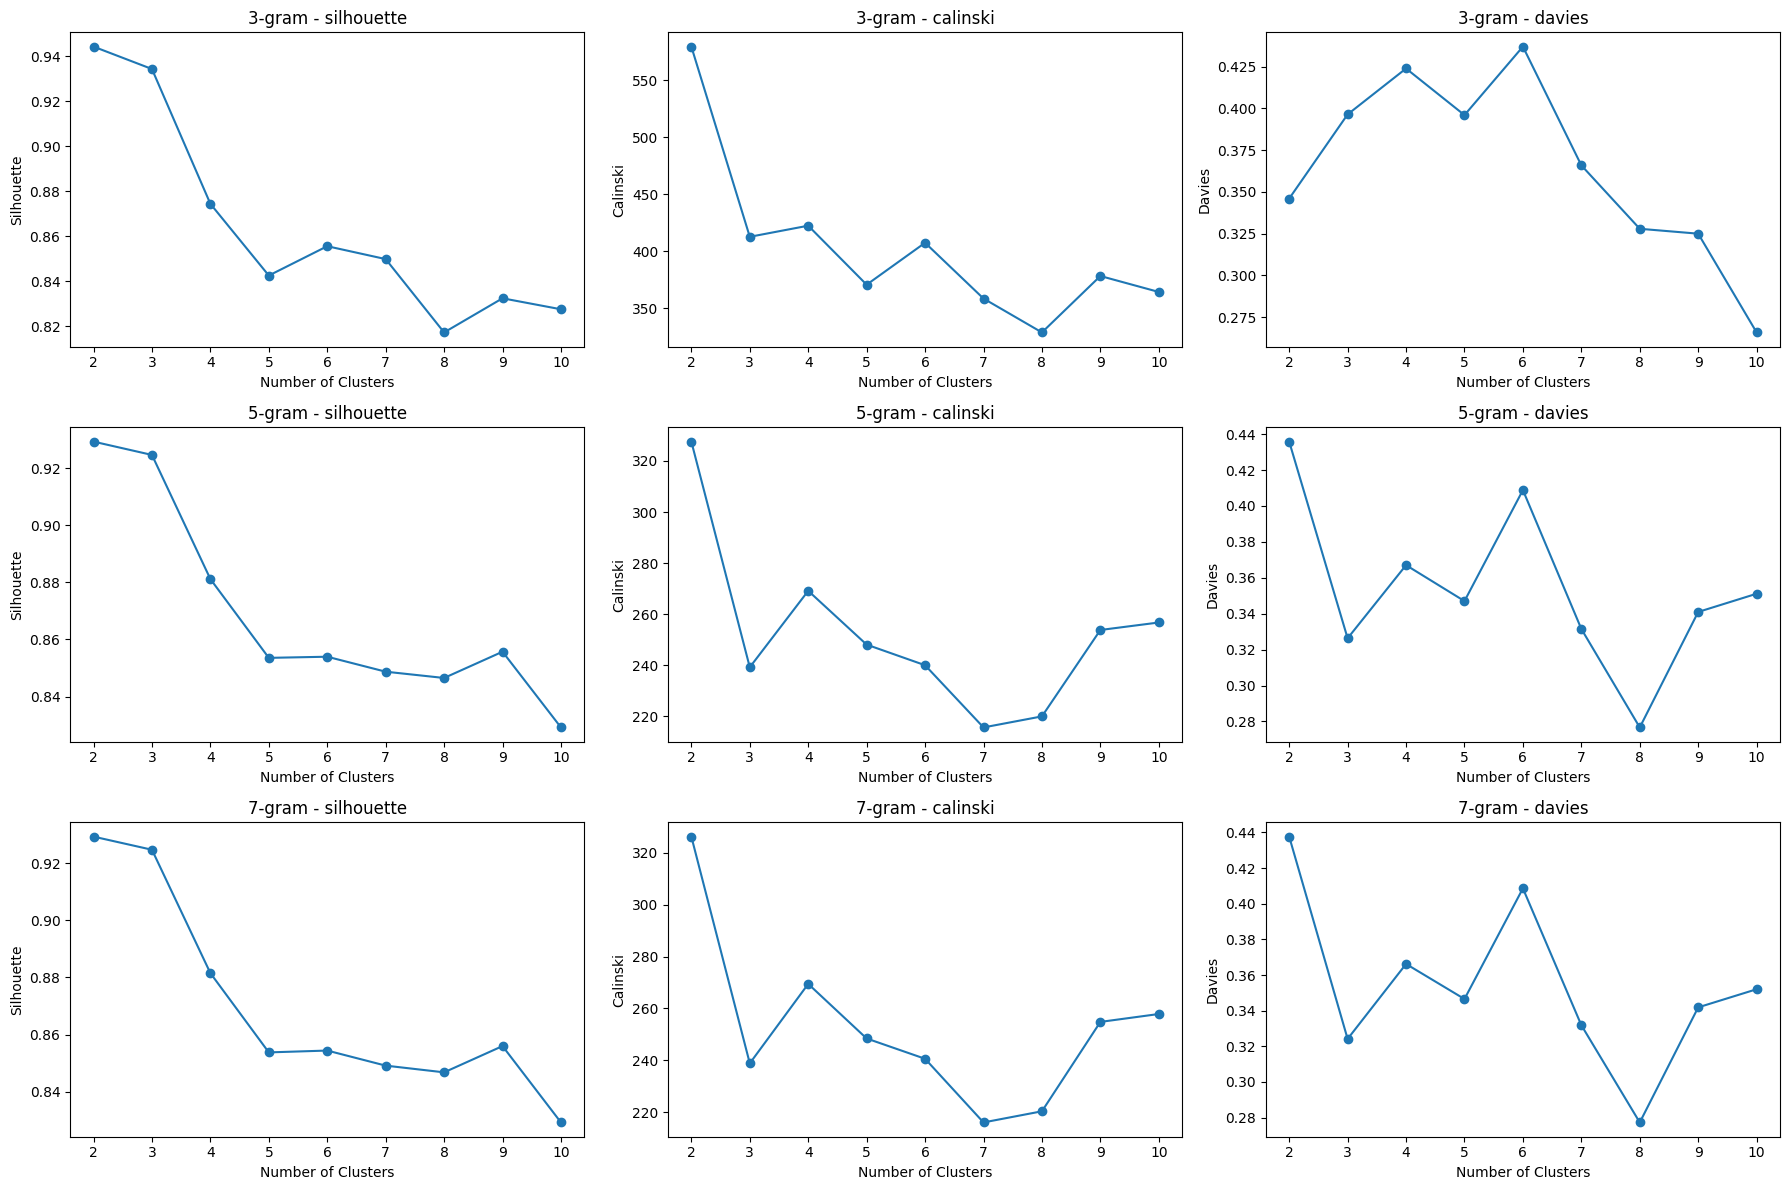

In [126]:
kmeans_clustering(datasets)

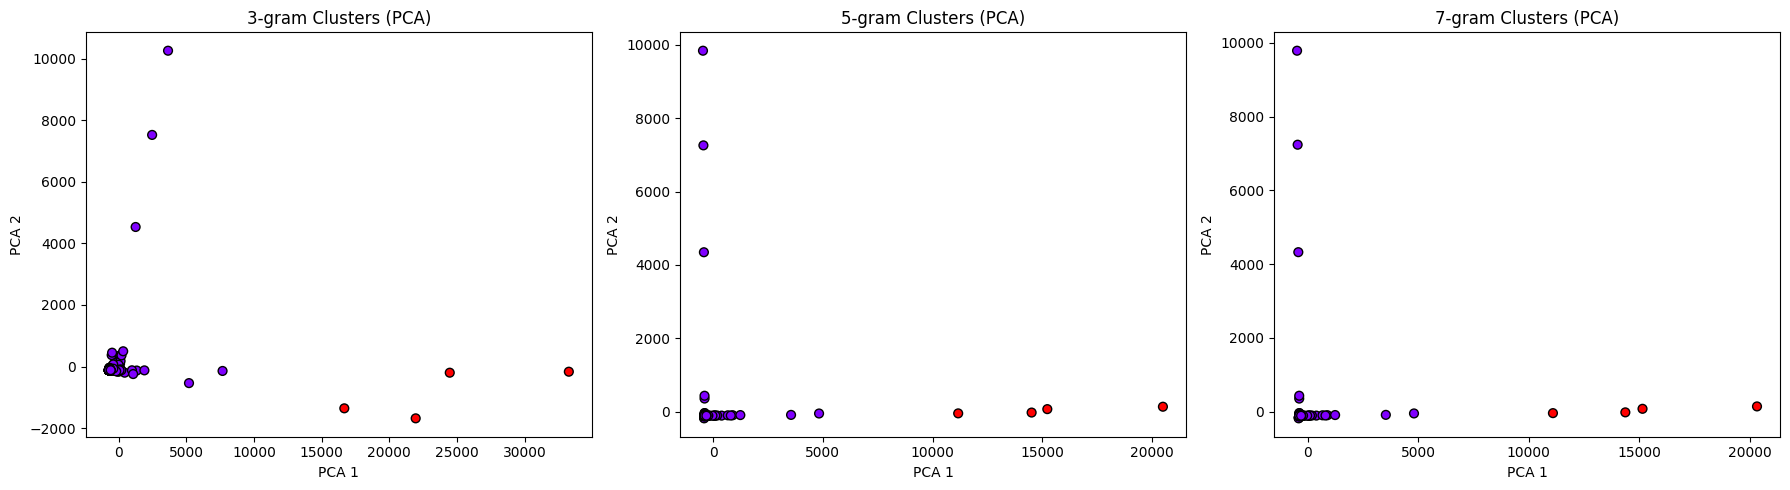

In [127]:
# Visualisation of clusterings
k = 2 #k = 8
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, data) in zip(axes, datasets.items()):
    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(data)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(data)

    # Scatter plot
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap="rainbow", s=40, edgecolor='k')
    ax.set_title(f"{label} Clusters (PCA)")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

#  Hierarchical Clustering

In [128]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

In [129]:
def hierarchical_clustering(datasets):
    cluster_range = range(2, 11)
    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} for ngram in datasets}
    
    # Grid search
    for ngram, data in datasets.items():
        for k in cluster_range:
            model = AgglomerativeClustering(n_clusters=k)
            labels = model.fit_predict(data)
            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data, labels))
    
    # Plot metric scores for each n-gram
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    metrics = ["silhouette", "calinski", "davies"]
    
    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Number of Clusters")
            ax.set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

### Ebola Virus

In [130]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_ebola.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

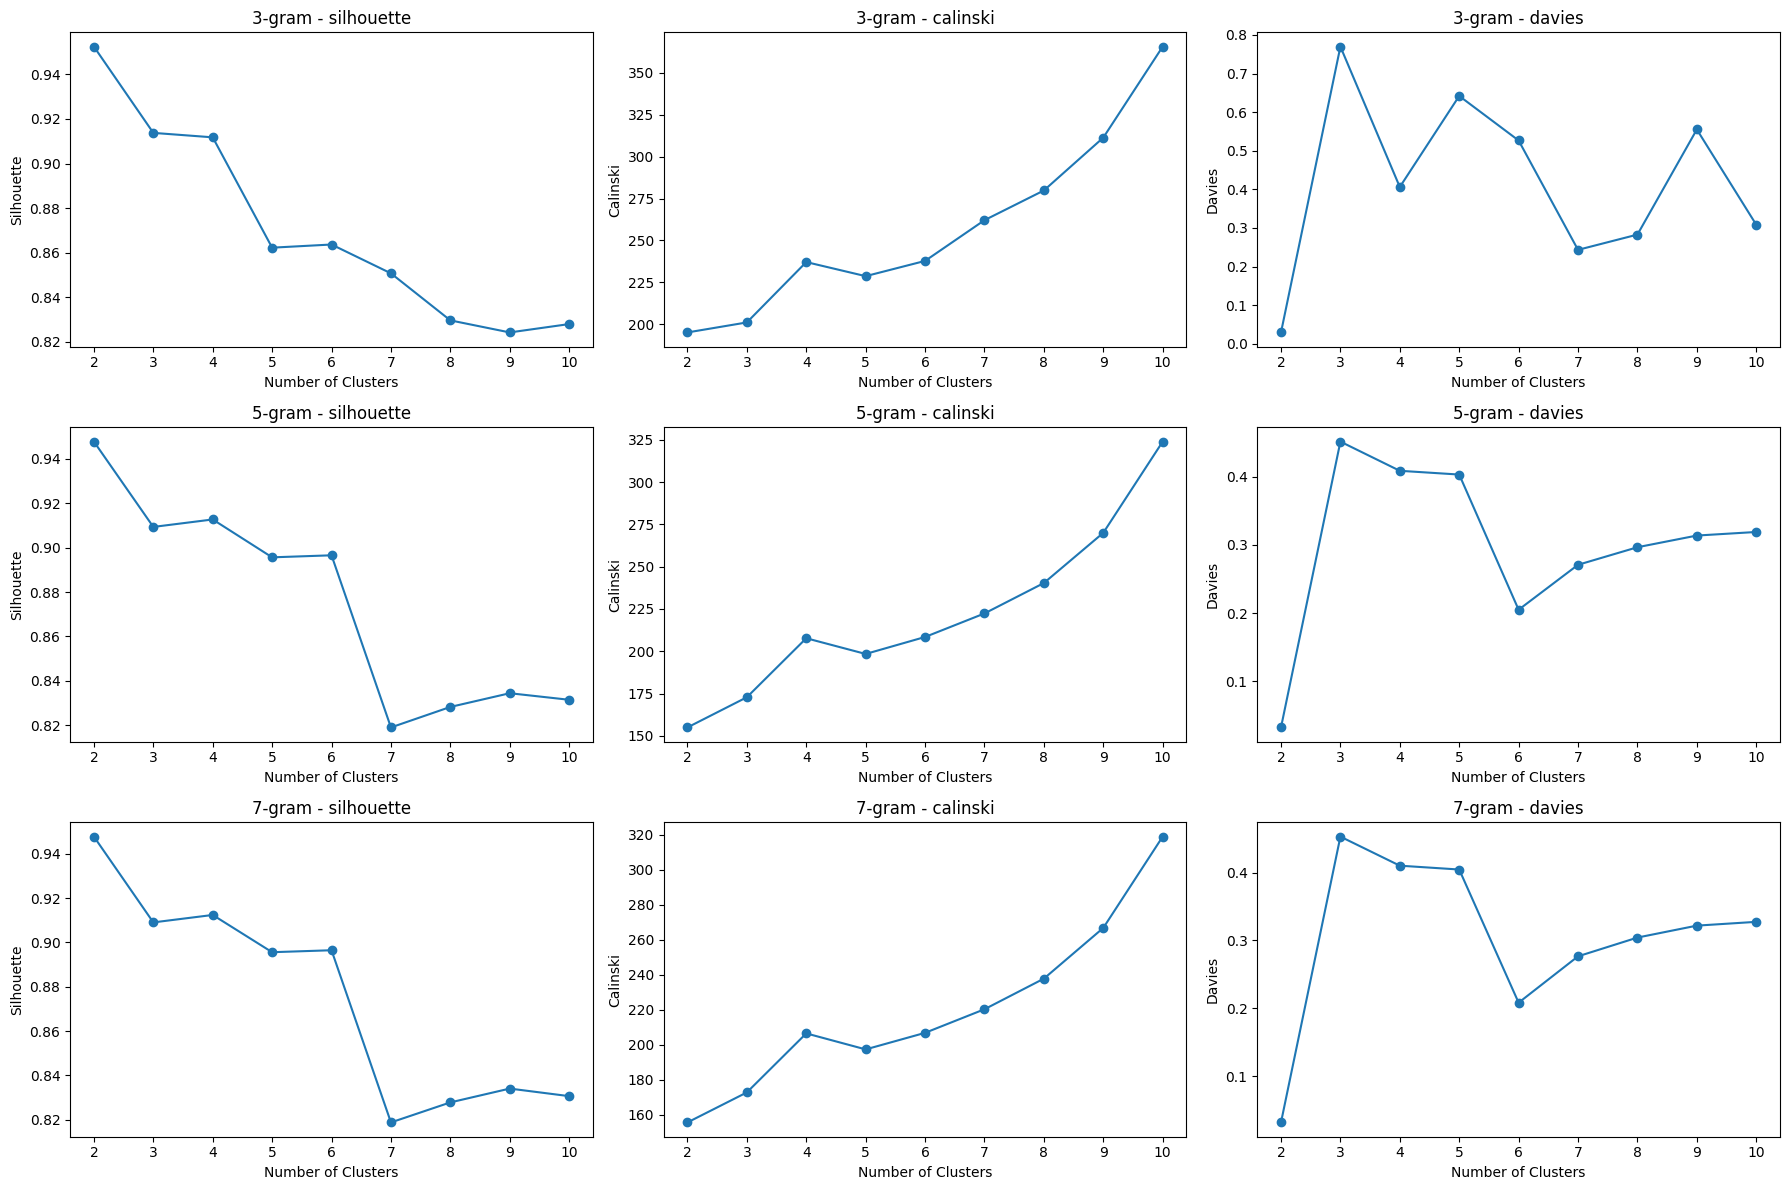

In [131]:
hierarchical_clustering(datasets)

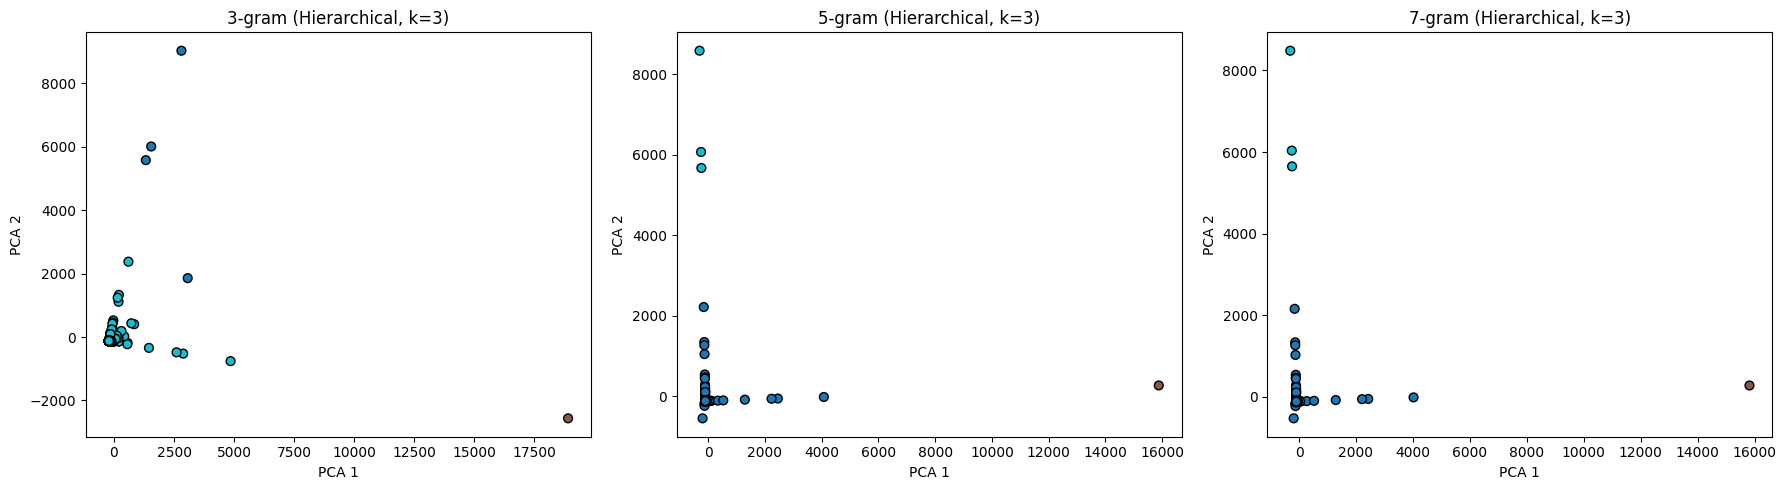

In [132]:
# PCA visualization
k = 3
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (ngram, data) in zip(axes, datasets.items()):
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(data)
    
    model = AgglomerativeClustering(n_clusters=k)
    clusters = model.fit_predict(data)
    
    ax.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', s=40, edgecolor='k')
    ax.set_title(f"{ngram} (Hierarchical, k={k})")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


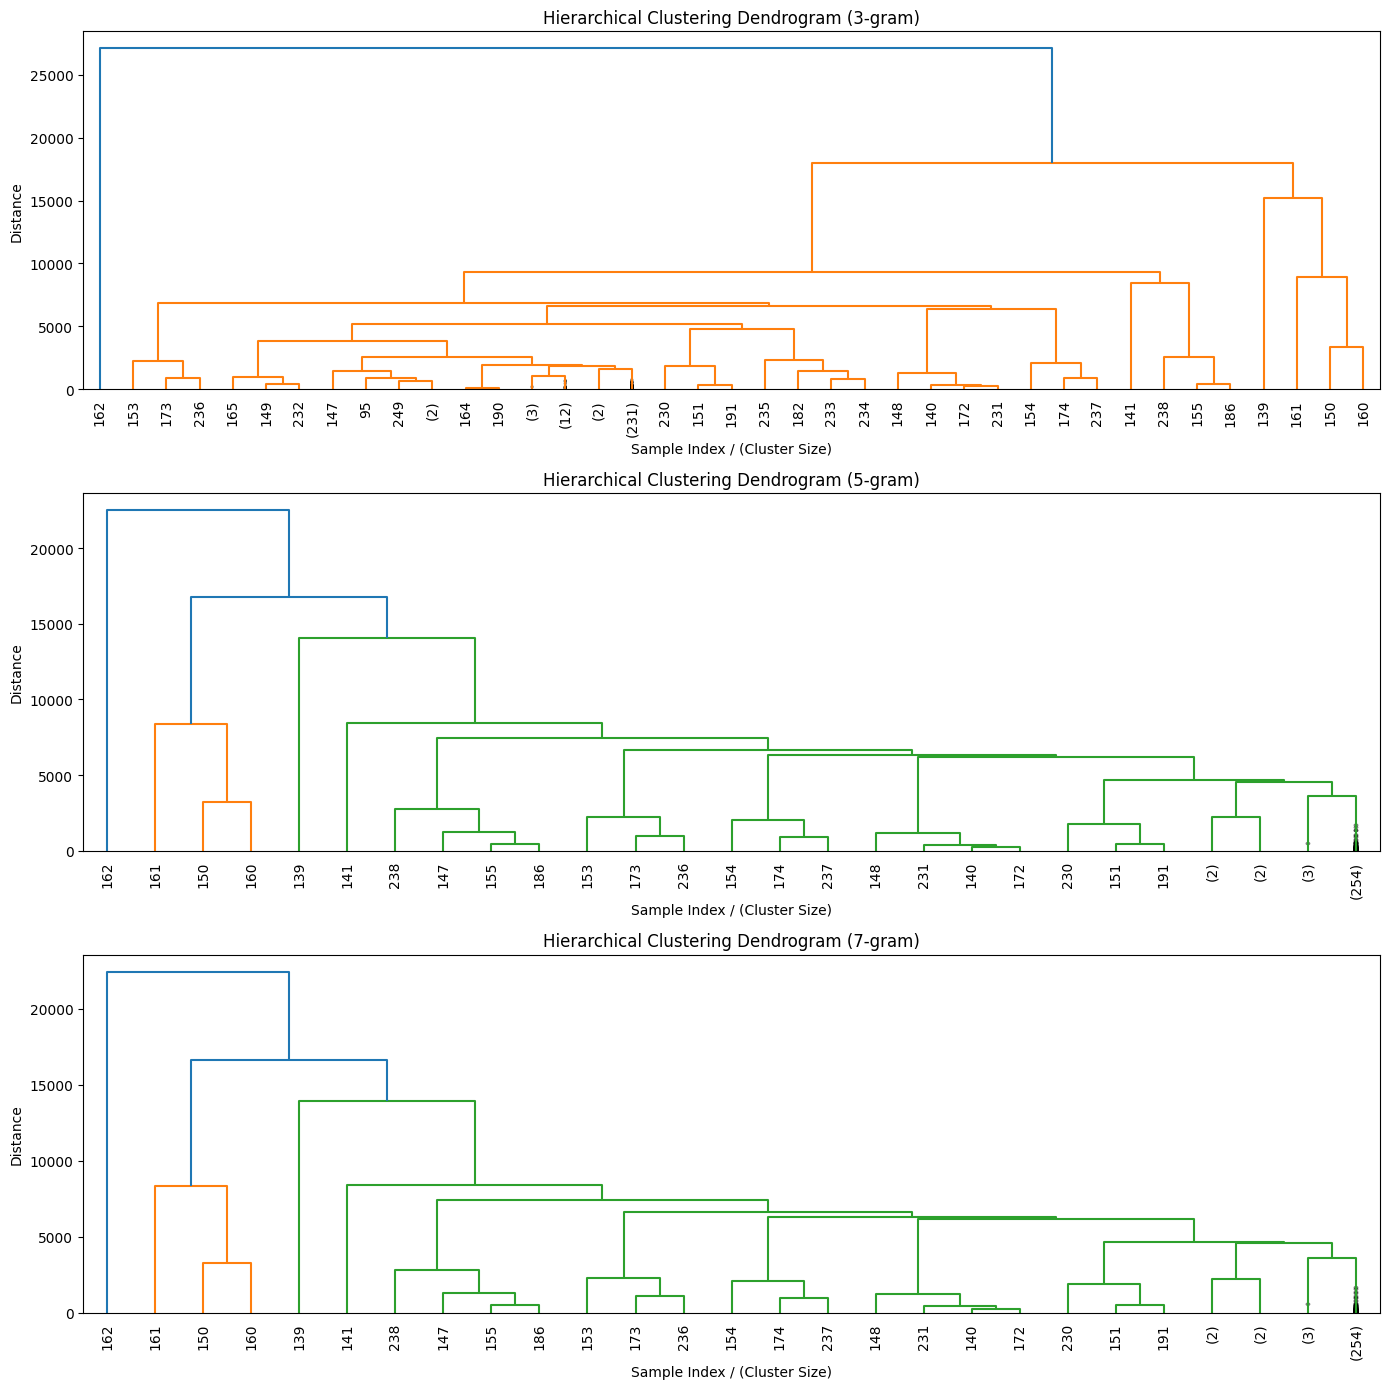

In [133]:
# Plot dendrograms
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

for ax, (label, data) in zip(axes, datasets.items()):
    linked = linkage(data, method='ward')
    
    dendrogram(linked,
               truncate_mode='level',
               p=10,
               ax=ax,
               leaf_rotation=90.,
               leaf_font_size=10.,
               show_contracted=True)
    
    ax.set_title(f"Hierarchical Clustering Dendrogram ({label})")
    ax.set_xlabel("Sample Index / (Cluster Size)")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.show()

### Marburg Virus

In [134]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_marburg.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

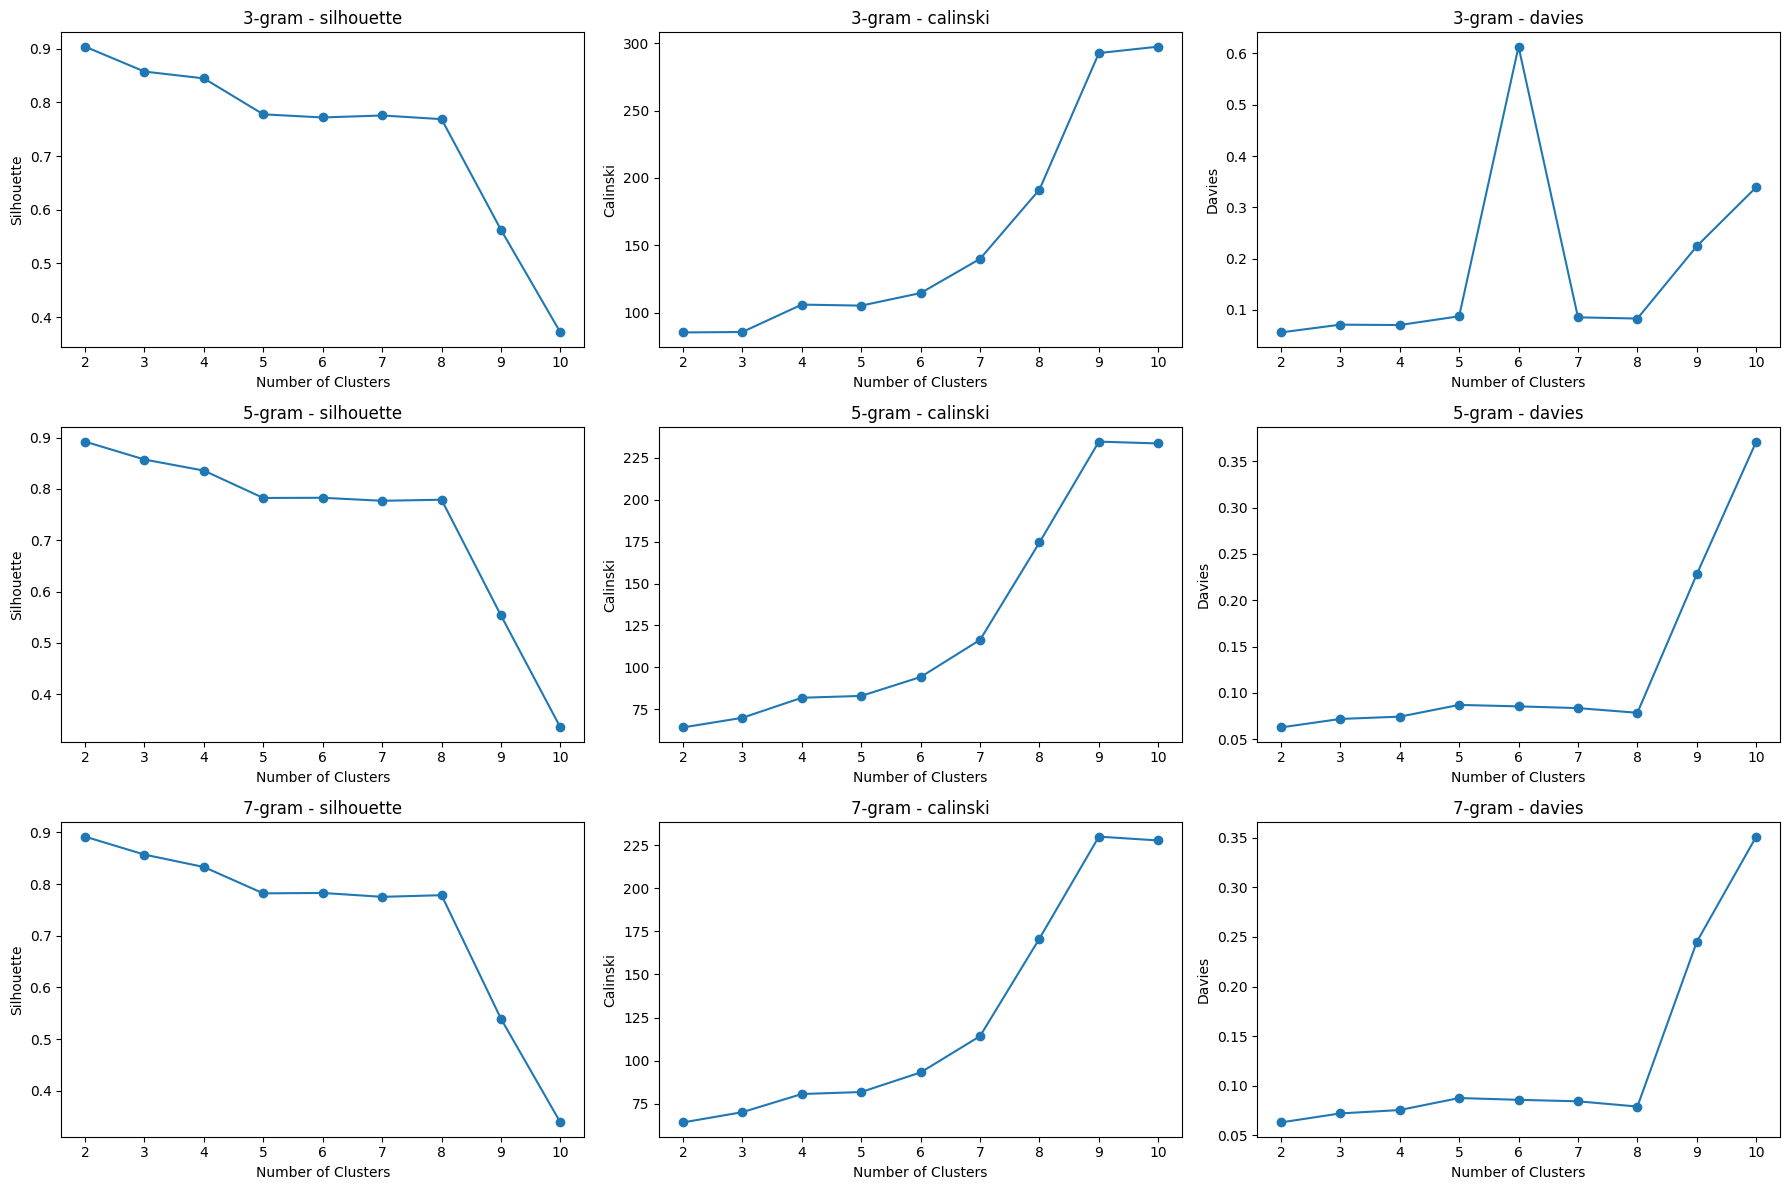

In [135]:
hierarchical_clustering(datasets)

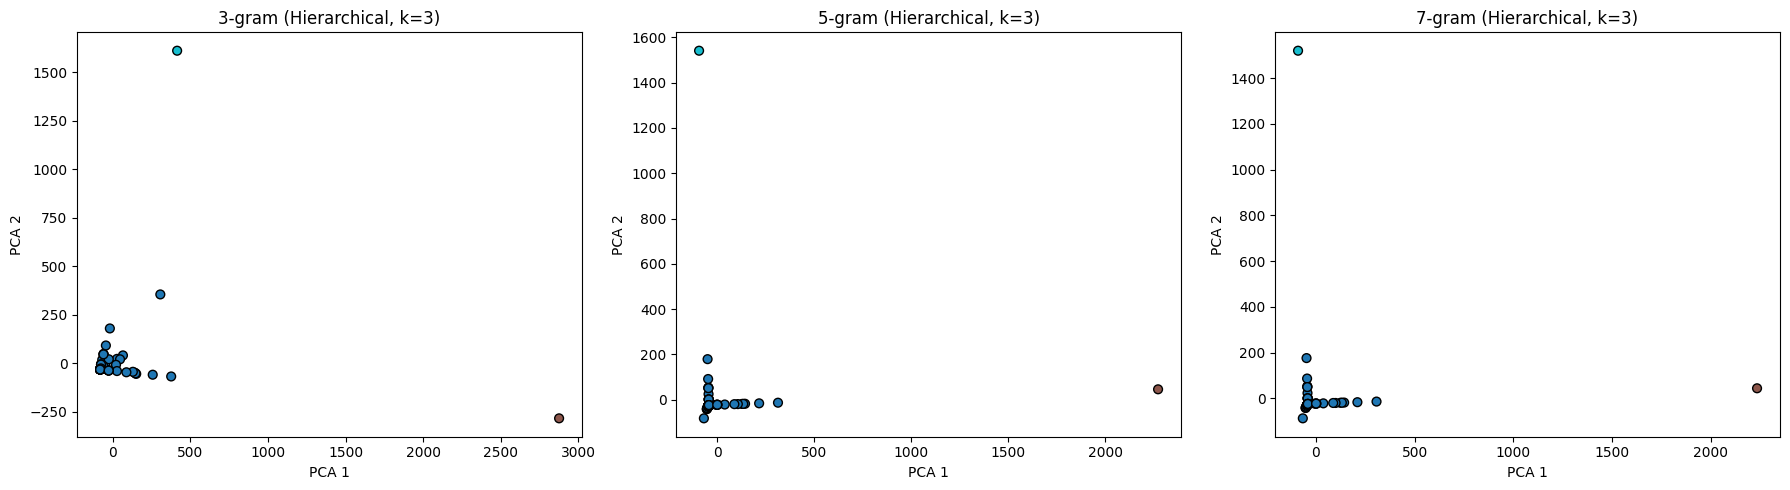

In [136]:
# PCA visualization
k = 3
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (ngram, data) in zip(axes, datasets.items()):
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(data)
    
    model = AgglomerativeClustering(n_clusters=k)
    clusters = model.fit_predict(data)
    
    ax.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', s=40, edgecolor='k')
    ax.set_title(f"{ngram} (Hierarchical, k={k})")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


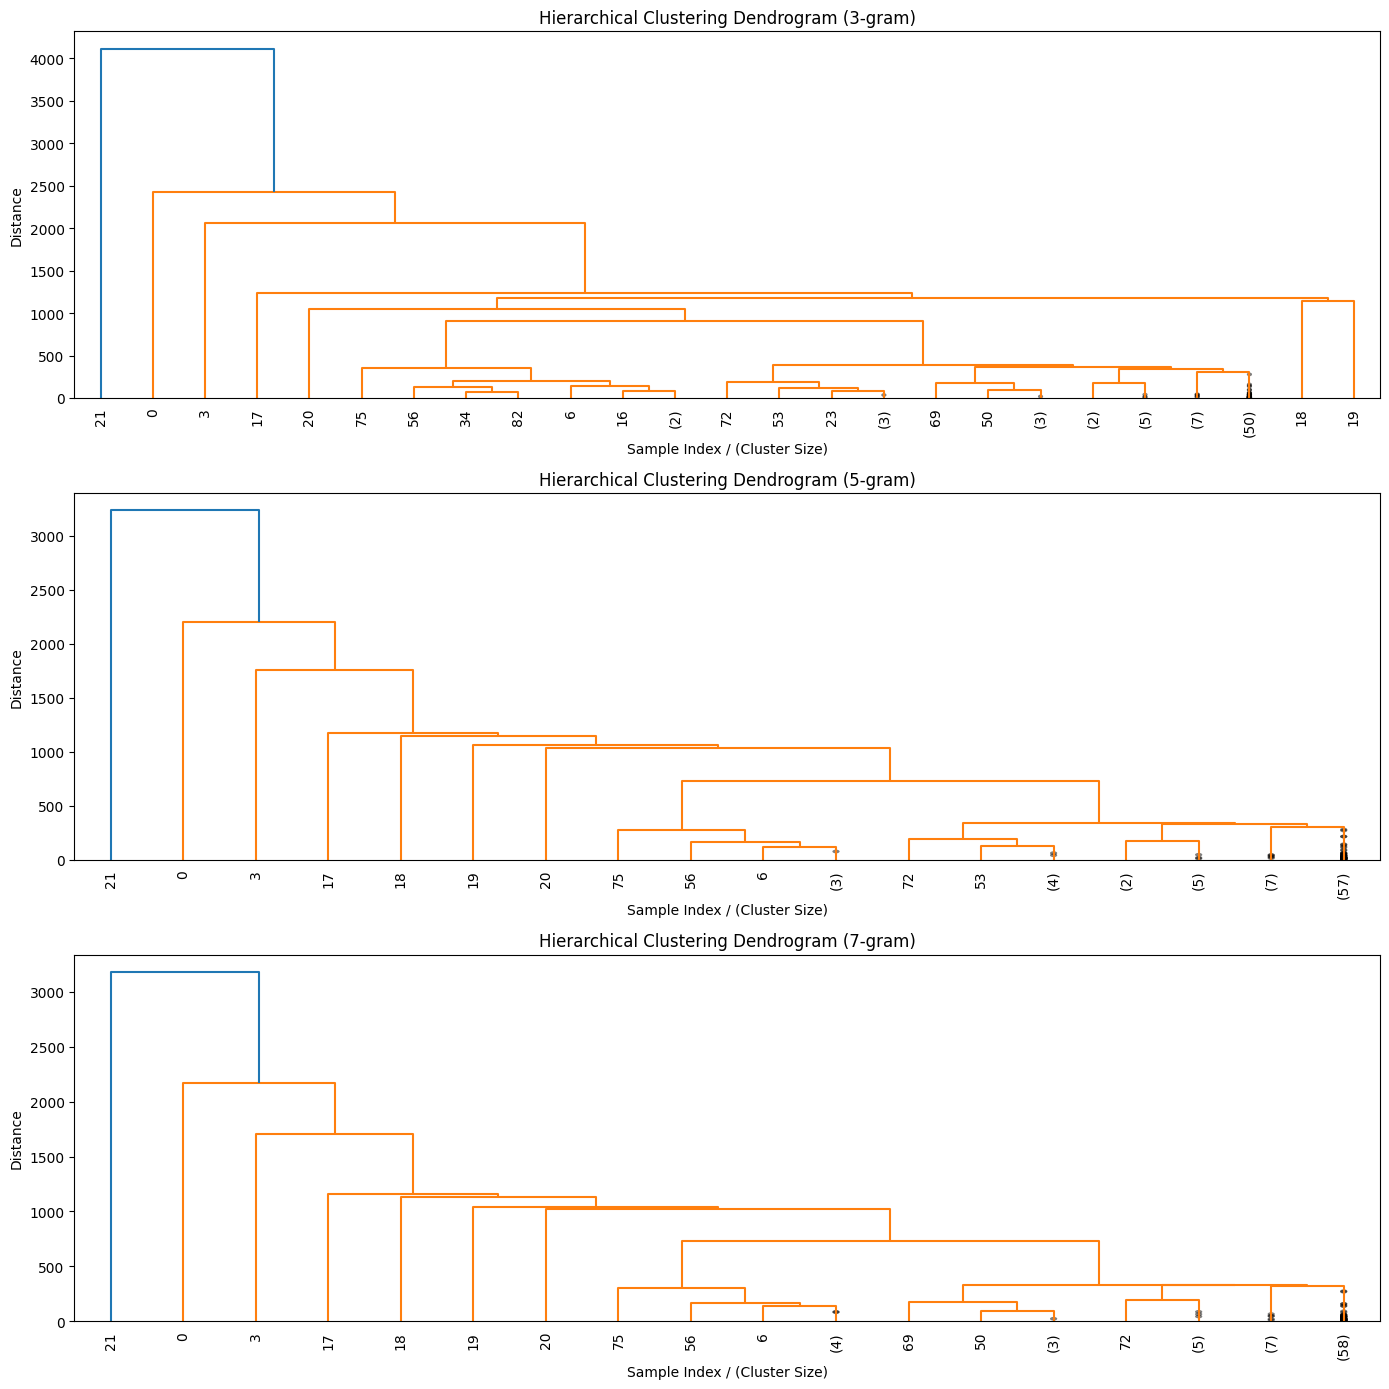

In [137]:
# Plot dendrograms
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

for ax, (label, data) in zip(axes, datasets.items()):
    linked = linkage(data, method='ward')
    
    dendrogram(linked,
               truncate_mode='level',
               p=10,
               ax=ax,
               leaf_rotation=90.,
               leaf_font_size=10.,
               show_contracted=True)
    
    ax.set_title(f"Hierarchical Clustering Dendrogram ({label})")
    ax.set_xlabel("Sample Index / (Cluster Size)")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.show()

### Mers Virus

In [138]:
df3 = pd.read_csv("../csv_data/3gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
df5 = pd.read_csv("../csv_data/5gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
df7 = pd.read_csv("../csv_data/7gram_matrix_amino_acid_mers.csv").drop(columns=["virus_type", "protein_type"])
datasets = {"3-gram": df3, "5-gram": df5, "7-gram": df7}

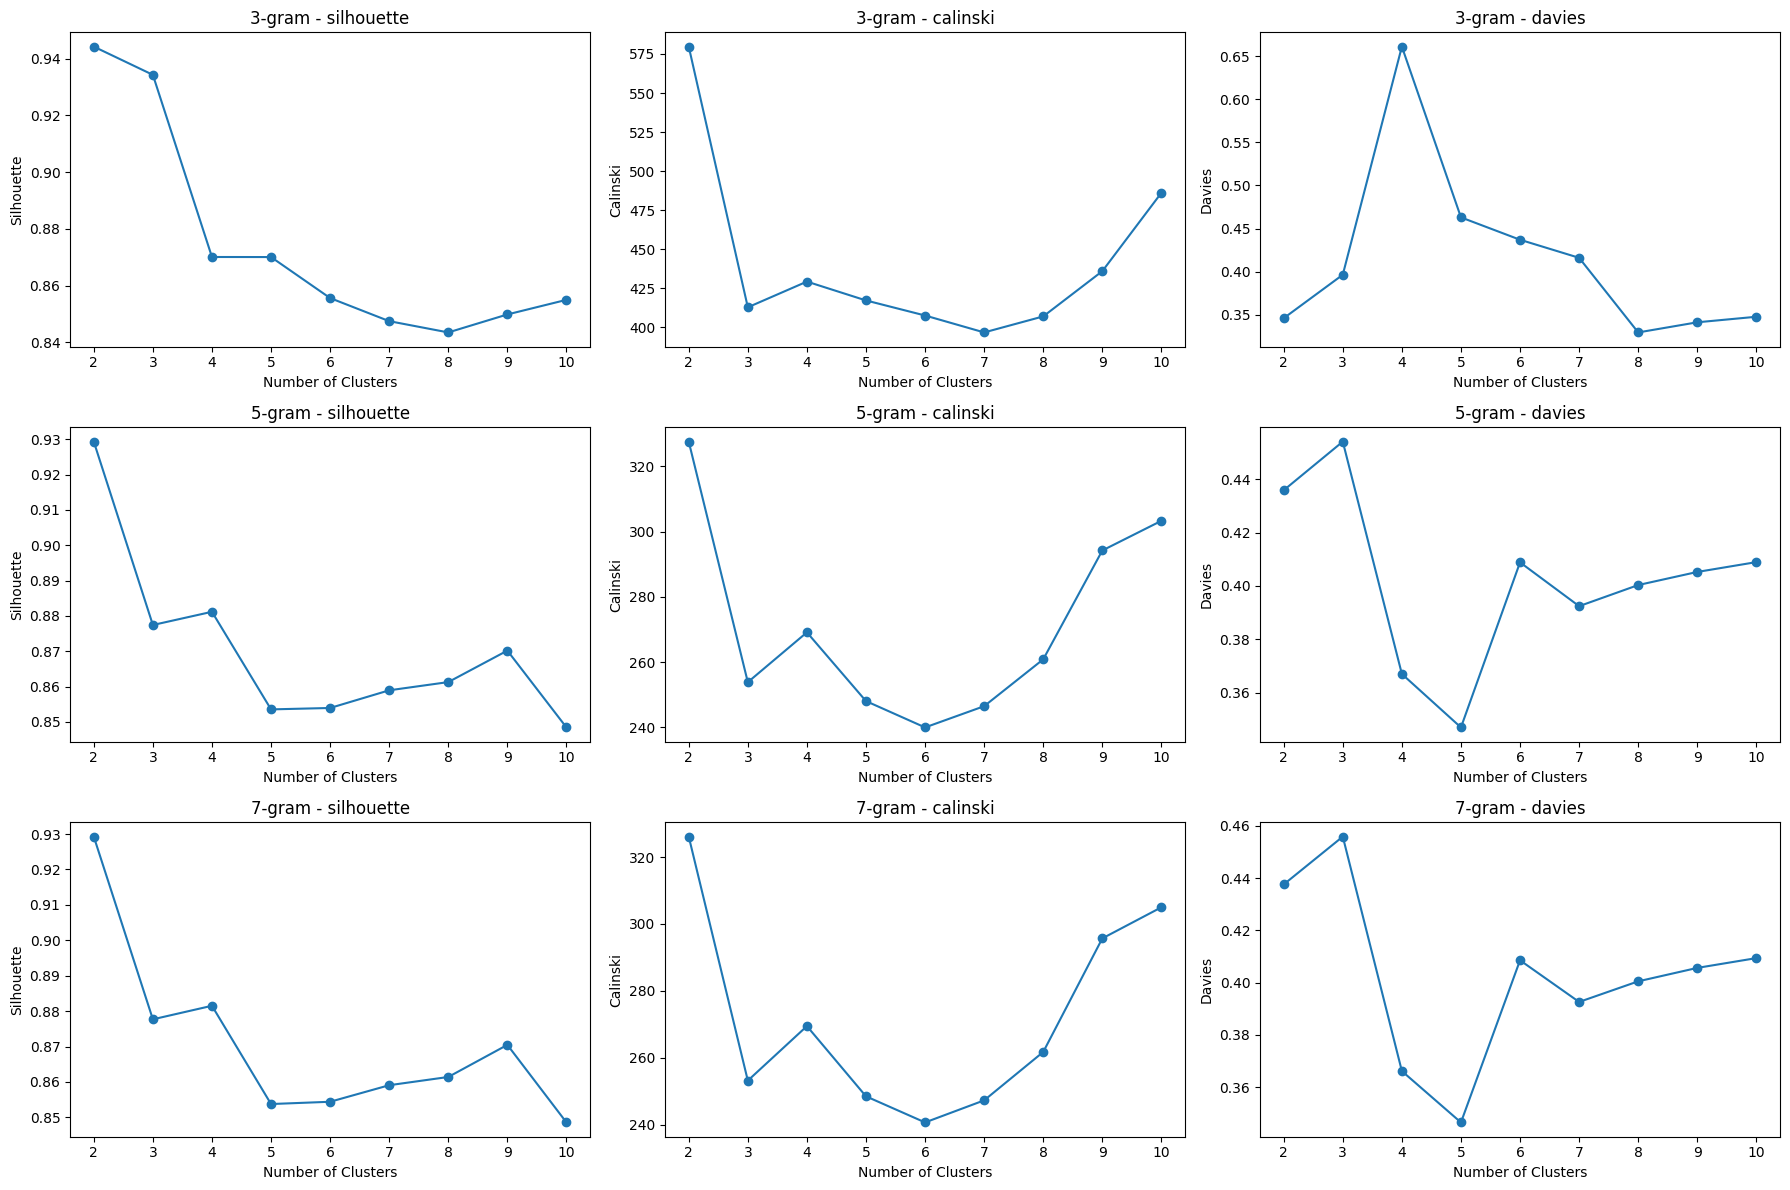

In [139]:
hierarchical_clustering(datasets)

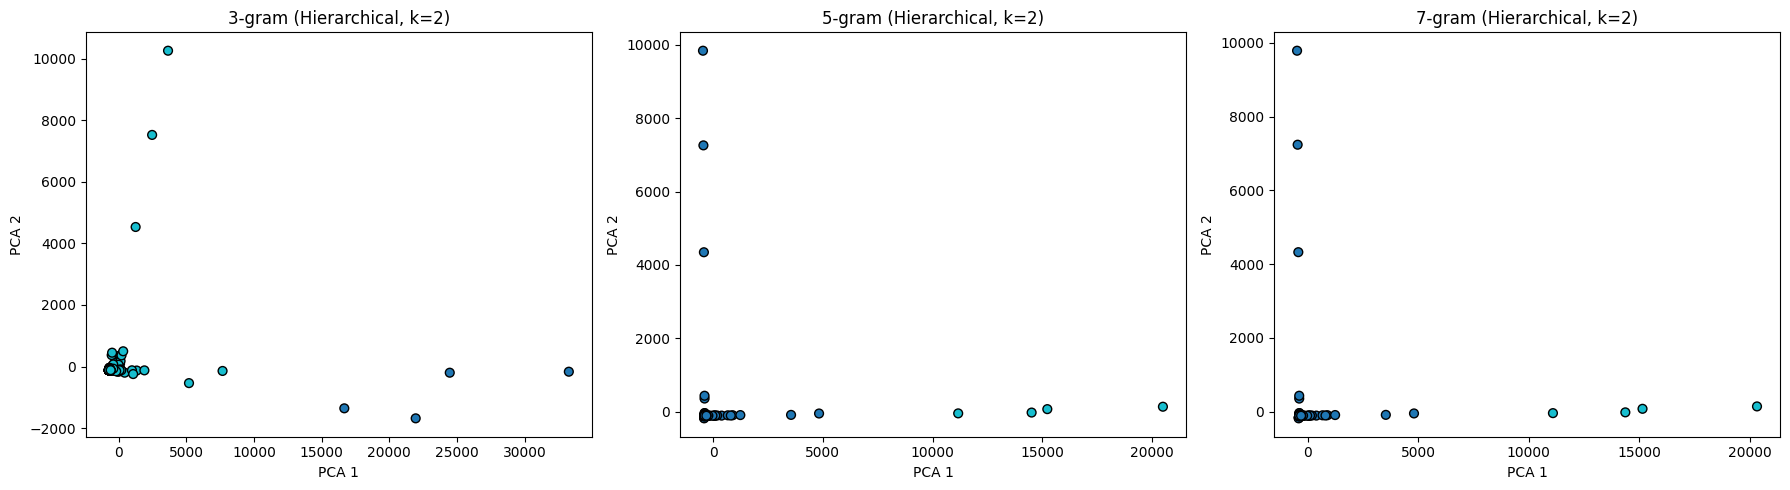

In [140]:
# PCA visualization
k = 2
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (ngram, data) in zip(axes, datasets.items()):
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(data)
    
    model = AgglomerativeClustering(n_clusters=k)
    clusters = model.fit_predict(data)
    
    ax.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', s=40, edgecolor='k')
    ax.set_title(f"{ngram} (Hierarchical, k={k})")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

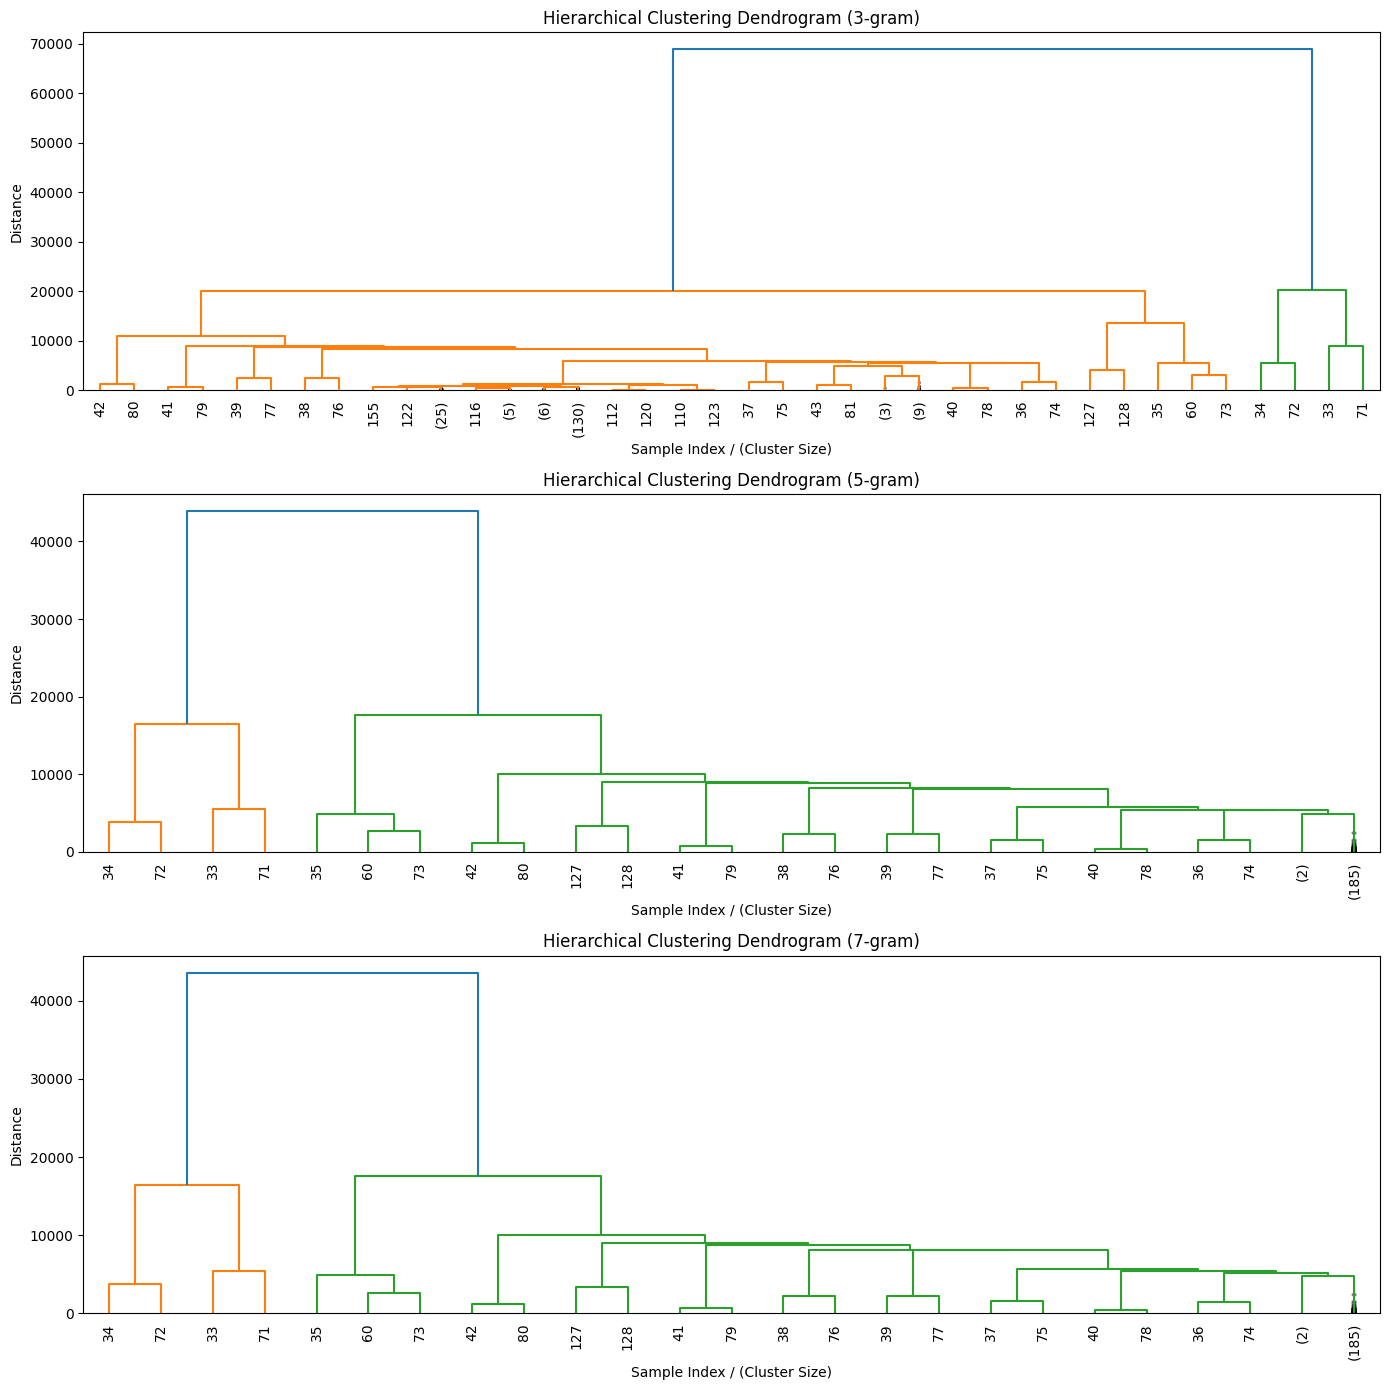

In [141]:
# Plot dendrograms
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

for ax, (label, data) in zip(axes, datasets.items()):
    linked = linkage(data, method='ward')
    
    dendrogram(linked,
               truncate_mode='level',
               p=10,
               ax=ax,
               leaf_rotation=90.,
               leaf_font_size=10.,
               show_contracted=True)
    
    ax.set_title(f"Hierarchical Clustering Dendrogram ({label})")
    ax.set_xlabel("Sample Index / (Cluster Size)")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.show()